In [3]:
import numpy as np
import os
import h5py
import matplotlib.pyplot as plt
import math
import sys
import time
from tqdm import tnrange, tqdm_notebook
import matplotlib.pyplot as plt
import operator
from matplotlib.backends.backend_pdf import PdfPages
import scipy.io
from matplotlib.gridspec import GridSpec

# Neural Matrix

In [4]:
def make_neural_matrix(spike_train_file, image_times_file, sorted_units_file, drop_no, save_dir):
    train_times = np.asarray(h5py.File(image_times_file, 'r')["image_times"])[0,:]
    train_images = train_times.shape[0]
    train_times = np.append(train_times, 9999)
    
    
    #sorted_units = np.load(sorted_units_file)
    #drop_units = sorted_units[-drop_no:]
    #keep_units = sorted_units[:-drop_no]
    
    spike_train = np.load(spike_train_file)
    
    ##
    
    spike_times = spike_train[:,0] / 20000
    units = np.max(spike_train[:,1]).astype(np.int) + 1
    ##
    
    #### DROP LOWEST WEIGHT XXXX UNITS ####
    #spike_train = spike_train[np.in1d(spike_train[:,1], drop_units, invert = True),:]
    #spike_times = spike_train[:,0] / 20000
    
    #units = keep_units.shape[0]
    ########
    
    
    train_matrix = np.empty((train_images, units * 2))
    bin_edges = np.copy(train_times)

    for i in tnrange(int(train_images)):
        
        bin1_start = train_times[i] + 0.03
        bin1_end = train_times[i] + 0.15
        
        bin2_start = train_times[i] + 0.17
        bin2_end = train_times[i] + 0.3
        
        bin_edges = np.append(bin_edges, bin1_start)
        bin_edges = np.append(bin_edges, bin1_end)
        bin_edges = np.append(bin_edges, bin2_start)
        bin_edges = np.append(bin_edges, bin2_end)

    bin_edges = np.sort(bin_edges)
    print(bin_edges.shape)

    hist_spikes, hist_edges = np.histogram(spike_times, bin_edges)
    
    count = spike_times.shape[0] - np.sum(hist_spikes)
    
    for i in tnrange(hist_spikes.shape[0]):
        
        bin_count = hist_spikes[i]

        if i%5 == 0:
            count += bin_count
            
        elif i%5 == 1:
            for j in range(bin_count):
                
                unit = int(spike_train[count,1])
                train_matrix[i//5,unit*2] += 1
                count +=1
                
                ###### DROP UNTIS ###
                #unit = int(spike_train[count,1])
                #index = np.where(keep_units == unit)[0]
                #train_matrix[i//5, index*2] += 1
                #count += 1
                
                ####
            
        elif i%5 == 2:
            count += bin_count
        
        elif i%5==3:
            for j in range(bin_count):
                
                unit = int(spike_train[count,1])
                train_matrix[i//5,unit*2+1] += 1
                count +=1
                
                ###### DROP UNTIS ###
                #unit = int(spike_train[count,1])
                #index = np.where(keep_units == unit)[0]
                #train_matrix[i//5, index*2+1] += 1
                #count += 1
                
                ####
        
        elif i%5==4:
            count += bin_count
        
    print(count)
    print(spike_train.shape)
    
    train_matrix = np.concatenate((train_matrix, np.ones((train_images, 1))), axis=1)
    
    test_matrix = train_matrix[9900:,:]
    valid_matrix = train_matrix[9800:9900, :]
    train_matrix = train_matrix[:9800,:]
    
    print(train_matrix.shape)
    print(test_matrix.shape)
    print(valid_matrix.shape)
    print(np.sum(train_matrix) + np.sum(test_matrix) + np.sum(valid_matrix))
    
    np.save(os.path.join(save_dir, "unsorted_smooth_train_neural.npy"), train_matrix)
    np.save(os.path.join(save_dir, "unsorted_smooth_test_neural.npy"), test_matrix)
    np.save(os.path.join(save_dir, "unsorted_smooth_valid_neural.npy"), valid_matrix)
    
    
def make_resid_neural_matrix(spike_train_file, resid_file, image_times_file, save_dir):
    
    train_times = np.asarray(h5py.File(image_times_file, 'r')["image_times"])[0,:]
    train_images = train_times.shape[0]
    train_times = np.append(train_times, 9999)
    
    spike_train = np.load(spike_train_file)
    residuals = np.load(resid_file)
    found_units = int(np.max(spike_train[:,1])+1)
    residuals[:, 1] += found_units
    
    full_spike_train = np.vstack((spike_train, residuals))
    full_spike_train = full_spike_train[full_spike_train[:,0].argsort()]

    full_spike_times = full_spike_train[:,0] / 20000
    full_units = np.max(full_spike_train[:,1]).astype(np.int) + 1
    
    train_matrix = np.empty((train_images, full_units * 2))
    bin_edges = np.copy(train_times)
    
    for i in tnrange(int(train_images)):
        
        bin1_start = train_times[i] + 0.03
        bin1_end = train_times[i] + 0.15
        
        bin2_start = train_times[i] + 0.17
        bin2_end = train_times[i] + 0.3
        
        bin_edges = np.append(bin_edges, bin1_start)
        bin_edges = np.append(bin_edges, bin1_end)
        bin_edges = np.append(bin_edges, bin2_start)
        bin_edges = np.append(bin_edges, bin2_end)

    bin_edges = np.sort(bin_edges)
    print(bin_edges.shape)

    hist_spikes, hist_edges = np.histogram(full_spike_times, bin_edges)
    
    count = full_spike_times.shape[0] - np.sum(hist_spikes)
    
    for i in tnrange(hist_spikes.shape[0]):
        
        bin_count = hist_spikes[i]

        if i%5 == 0:
            count += bin_count
            
        elif i%5 == 1:
            for j in range(bin_count):
                
                unit = int(full_spike_train[count,1])
                train_matrix[i//5,unit*2] += 1
                count +=1
            
        elif i%5 == 2:
            count += bin_count
        
        elif i%5==3:
            for j in range(bin_count):
                
                unit = int(full_spike_train[count,1])
                train_matrix[i//5,unit*2+1] += 1
                count +=1
        
        elif i%5==4:
            count += bin_count
        
    print(count)
    print(full_spike_train.shape)
    
    train_matrix = np.concatenate((train_matrix, np.ones((train_images, 1))), axis=1)
    
    test_matrix = train_matrix[9900:,:]
    valid_matrix = train_matrix[9800:9900, :]
    train_matrix = train_matrix[:9800,:]
    
    print(train_matrix.shape)
    print(test_matrix.shape)
    print(valid_matrix.shape)
    print(np.sum(train_matrix) + np.sum(test_matrix) + np.sum(valid_matrix))
    
    np.save(os.path.join(save_dir, "resid_ks2_train_neural.npy"), train_matrix)
    np.save(os.path.join(save_dir, "resid_ks2_test_neural.npy"), test_matrix)
    np.save(os.path.join(save_dir, "resid_ks2_valid_neural.npy"), valid_matrix)
    

In [5]:
spike_train_file = "/ssd/joon/2017_11_29_ns/ks2/ks2_spiketrain.npy"
resid_file = "/ssd/joon/2017_11_29_ns/resid_ks2/ks2_resid_spiketrain.npy"
image_times_file = "/ssd/joon/2017_11_29_ns/trigger_times_201711290.mat"
#sorted_units_file = "/ssd/joon/2017_11_29_ns/yass/yass_weight_sorted_units.npy"
save_dir = "/ssd/joon/2017_11_29_ns/resid_ks2/"
#drop_no = 500

#make_neural_matrix(spike_train_file, image_times_file, sorted_units_file, drop_no, save_dir)
make_resid_neural_matrix(spike_train_file, resid_file, image_times_file, save_dir)


(50001,)



276853456
(276853456, 2)
(9800, 3603)
(100, 3603)
(100, 3603)
120571050.0


# Image Matrix

In [16]:
def make_image_matrix(movie_file, save_dir):
    movie = np.asarray(h5py.File(movie_file,'r')['movie'])[:,:,32:-32]
    image_no = int(movie.shape[0])
    
    stim_size0 = movie.shape[1]
    stim_size1 = movie.shape[2]
    
    image_matrix = np.empty((image_no,95 * 146)) ##### 95 x 146 #$###
    
    for i in tnrange(image_no):
        image = movie[i,:,:][25:-40,50:-60] ####
        image_matrix[i] = image.flatten()
        
    train_images = image_matrix[:9800,:]
    test_images = image_matrix[9900:,:]
    valid_images = image_matrix[9800:9900,:]
    
    print(train_images.shape)
    print(test_images.shape)
    print(valid_images.shape)
    
    np.save(os.path.join(save_dir,"train_images.npy"), train_images)
    np.save(os.path.join(save_dir,"test_images.npy"), test_images)
    np.save(os.path.join(save_dir,"valid_images.npy"), valid_images)
    
def make_smooth_image_matrix(movie_file, save_dir):
    
    movie = np.asarray(h5py.File(movie_file,'r')['movie'])[:,:,32:-32]
    image_no = int(movie.shape[0])
    
    stim_size0 = movie.shape[1]
    stim_size1 = movie.shape[2]
    
    image_matrix = np.empty((image_no,95 * 146))
    
    for i in tnrange(image_no):
        image = movie[i,:,:]
        smooth_image = scipy.ndimage.gaussian_filter(image, 
                                                     sigma=4, 
                                                     order=0, 
                                                     mode='constant', 
                                                     cval=0.0, 
                                                     truncate=3.0)
 
        image_matrix[i] = smooth_image[25:-40,50:-60].flatten()
        
    train_images = image_matrix[:9800,:]
    test_images = image_matrix[9900:,:]
    valid_images = image_matrix[9800:9900,:]
    
    print(train_images.shape)
    print(test_images.shape)
    print(valid_images.shape)
    
    np.save(os.path.join(save_dir,"smooth_train_images.npy"), train_images)
    np.save(os.path.join(save_dir,"smooth_test_images.npy"), test_images)
    np.save(os.path.join(save_dir,"smooth_valid_images.npy"), valid_images)
    

In [177]:
movie_file = "/ssd/joon/2017_11_29_ns/ImageNet_stix2_0_045.mat"
save_dir = "/ssd/joon/2017_11_29_ns/"

make_smooth_image_matrix(movie_file, save_dir)
#make_image_matrix(movie_file, save_dir)


(9800, 13870)
(100, 13870)
(100, 13870)


# Make Weights

In [8]:
def make_weights(neural_matrix_file, image_matrix_file, index, regularizer, save_dir):
    X = np.load(neural_matrix_file)
    Y = np.load(image_matrix_file)
    train_size = int(fraction * X.shape[0])

    XTX = np.matmul(X.T,X)
    XTX_inv = np.linalg.inv(XTX + regularizer * np.identity(XTX.shape[0]))
    XTY = np.matmul(X.T,Y)
    theta = np.matmul(XTX_inv,XTY)
    
    print(theta.shape)
    np.save(os.path.join(save_dir,"resid_ks2_" +str(index)+"_weights.npy"), theta)
    
def make_circle_weights(neural_matrix_file, image_matrix_file, index, radius, regularizer, save_dir):
    X = np.load(neural_matrix_file)
    Y = np.load(image_matrix_file)
    train_size = int(fraction * X.shape[0])
    sorted_units = np.load(sorted_unit_file)

    XTX = np.matmul(X.T,X)
    XTX_inv = np.linalg.inv(XTX + regularizer * np.identity(XTX.shape[0]))
    XTY = np.matmul(X.T,Y)
    theta = np.matmul(XTX_inv,XTY)
    
    theta_circle = np.empty((theta.shape[0], theta.shape[1]))
    print(theta.shape)
    
    for i in range(theta.shape[0]):
        weight = theta[i,:].reshape((95,146))
        abs_max = np.max(np.abs(weight))
        weight_list = np.ndarray.tolist(np.abs(weight))
        
        for j in range(weight.shape[0]):
            weight_row = weight_list[j]
            if abs_max in weight_row:
                center_x = j
                center_y = weight_row.index(abs_max)
        y,x = np.ogrid[-center_x:95-center_x, -center_y:146-center_y]
        zero_mask = x*x + y*y > radius * radius
        weight[zero_mask]=0
        
        theta_circle[i,:] = weight.flatten()

    np.save(os.path.join(save_dir,"yass_circle_" + str(index) + "_weights.npy"), theta_circle)
    
    
def multi_make_weights(neural_matrix_file, image_matrix_file, fraction, radius, save_dir):
    reg_list = np.logspace(3, 5, 10, endpoint=True)
    for i in tnrange(len(reg_list)):
        regularizer = reg_list[i]
        index = i
        
        make_weights(neural_matrix_file, image_matrix_file, index, regularizer, save_dir)
        #make_circle_weights(neural_matrix_file, image_matrix_file, index, radius, regularizer, save_dir)


In [9]:
neural_matrix_file = "/ssd/joon/2017_11_29_ns/resid_ks2/resid_ks2_train_neural.npy"
image_matrix_file = "/ssd/joon/2017_11_29_ns/smooth_train_images.npy"
save_dir = "/ssd/joon/2017_11_29_ns/resid_ks2/"

fraction = 1
radius = 45

multi_make_weights(neural_matrix_file, image_matrix_file, fraction, radius, save_dir)


(3603, 13870)
(3603, 13870)
(3603, 13870)
(3603, 13870)
(3603, 13870)
(3603, 13870)
(3603, 13870)
(3603, 13870)
(3603, 13870)
(3603, 13870)



# Decode

In [41]:
def decode_images(neural_matrix_file, weights_file, index, save_dir):
    X = np.load(neural_matrix_file)
    theta = np.load(weights_file)
    
    decoded = np.matmul(X, theta)
    
    np.save(os.path.join(save_dir,"resid_ks2_smooth_test_decoded.npy"), decoded)
    
def multi_decode_images(neural_matrix_file, w1_file, w2_file, w3_file, w4_file,
                       w5_file, w6_file, w7_file, w8_file, w9_file, w10_file, save_dir):
    
    w_files = [w1_file, w2_file, w3_file, w4_file, w5_file, w6_file, w7_file, w8_file, w9_file, w10_file]
    
    for i in tnrange(len(w_files)):
        w_file = w_files[i]
        
        decode_images(neural_matrix_file, w_file, i, save_dir)
  

In [42]:
neural_matrix_file = "/ssd/joon/2017_11_29_ns/resid_ks2/resid_ks2_test_neural.npy"
save_dir = "/ssd/joon/2017_11_29_ns/resid_ks2/"
weights_file = "/ssd/joon/2017_11_29_ns/resid_ks2/resid_ks2_smooth_1_weights.npy"
index=0

decode_images(neural_matrix_file, weights_file, index, save_dir)

"""
w1_file = "/ssd/joon/2017_11_29_ns/resid_ks2/resid_ks2_smooth_0_weights.npy"
w2_file = "/ssd/joon/2017_11_29_ns/resid_ks2/resid_ks2_smooth_1_weights.npy"
w3_file = "/ssd/joon/2017_11_29_ns/resid_ks2/resid_ks2_smooth_2_weights.npy"
w4_file = "/ssd/joon/2017_11_29_ns/resid_ks2/resid_ks2_smooth_3_weights.npy"
w5_file = "/ssd/joon/2017_11_29_ns/resid_ks2/resid_ks2_smooth_4_weights.npy"
w6_file = "/ssd/joon/2017_11_29_ns/resid_ks2/resid_ks2_smooth_5_weights.npy"
w7_file = "/ssd/joon/2017_11_29_ns/resid_ks2/resid_ks2_smooth_6_weights.npy"
w8_file = "/ssd/joon/2017_11_29_ns/resid_ks2/resid_ks2_smooth_7_weights.npy"
w9_file = "/ssd/joon/2017_11_29_ns/resid_ks2/resid_ks2_smooth_8_weights.npy"
w10_file = "/ssd/joon/2017_11_29_ns/resid_ks2/resid_ks2_smooth_9_weights.npy"

multi_decode_images(neural_matrix_file, w1_file, w2_file, w3_file, w4_file,
                       w5_file, w6_file, w7_file, w8_file, w9_file, w10_file, save_dir)
"""

'\nw1_file = "/ssd/joon/2017_11_29_ns/resid_ks2/resid_ks2_smooth_0_weights.npy"\nw2_file = "/ssd/joon/2017_11_29_ns/resid_ks2/resid_ks2_smooth_1_weights.npy"\nw3_file = "/ssd/joon/2017_11_29_ns/resid_ks2/resid_ks2_smooth_2_weights.npy"\nw4_file = "/ssd/joon/2017_11_29_ns/resid_ks2/resid_ks2_smooth_3_weights.npy"\nw5_file = "/ssd/joon/2017_11_29_ns/resid_ks2/resid_ks2_smooth_4_weights.npy"\nw6_file = "/ssd/joon/2017_11_29_ns/resid_ks2/resid_ks2_smooth_5_weights.npy"\nw7_file = "/ssd/joon/2017_11_29_ns/resid_ks2/resid_ks2_smooth_6_weights.npy"\nw8_file = "/ssd/joon/2017_11_29_ns/resid_ks2/resid_ks2_smooth_7_weights.npy"\nw9_file = "/ssd/joon/2017_11_29_ns/resid_ks2/resid_ks2_smooth_8_weights.npy"\nw10_file = "/ssd/joon/2017_11_29_ns/resid_ks2/resid_ks2_smooth_9_weights.npy"\n\nmulti_decode_images(neural_matrix_file, w1_file, w2_file, w3_file, w4_file,\n                       w5_file, w6_file, w7_file, w8_file, w9_file, w10_file, save_dir)\n'

# Validation Plots

In [35]:
def valid_calc(valid_file, ten1_file, ten2_file, ten3_file, ten4_file, ten5_file, ten6_file, 
               ten7_file, ten8_file, ten9_file, ten10_file, save_dir):
    valid_images = np.load(valid_file)
    ten1 = np.load(ten1_file)
    ten2 = np.load(ten2_file)
    ten3 = np.load(ten3_file)
    ten4 = np.load(ten4_file)
    ten5 = np.load(ten5_file)
    ten6 = np.load(ten6_file)
    ten7 = np.load(ten7_file)
    ten8 = np.load(ten8_file)
    ten9 = np.load(ten9_file)
    ten10 = np.load(ten10_file)
    
    images_array = [ten1, ten2, ten3, ten4, ten5, ten6, ten7, ten8, ten9, ten10]
    valid_array = np.empty((len(images_array)))
    
    """
    ##### MSE CALCULATIOn #####
    
    for i in range(len(images_array)):
        valid_value = np.sum((valid_images - images_array[i]) ** 2)/valid_images.shape[0]
        valid_array[i] = valid_value
    """
    
    ##### PIXEL WISE CORRELATION ###
    
    for i in tnrange(len(images_array)):
        corr_sum = 0
        exp_images = images_array[i]
        
        
        for j in range(valid_images.shape[1]):
            valid_pixels = valid_images[:,j]
            exp_pixels = exp_images[:,j]
            
            corr_value = np.corrcoef(valid_pixels, exp_pixels)[0][1]
            
            corr_sum += corr_value
        
        corr_sum = corr_sum/valid_images.shape[1]
        valid_array[i] = corr_sum

    np.save(os.path.join(save_dir, "resid_ks2_smooth_valid_corr.npy"), valid_array)
    
def valid_plot(yass_mse_file, ks2_mse_file, unsorted_mse_file, save_dir):
    yass_mse = np.load(yass_mse_file)
    ks2_mse = np.load(ks2_mse_file)
    unsorted_mse = np.load(unsorted_mse_file)
    x_vals = ["1.0*10^3", "1.7*10^3", "2.8*10^3", "4.6*10^3", "7.7*10^3",
             "1.3*10^4", "2.2*10^4", "3.6*10^4", "6.0*10^4", "1.0*10^5"]
    
    fig, axs = plt.subplots(nrows=1, figsize=(10, 5))
    
    yass = axs.bar(x_vals, yass_mse, color = "Red")
    #ks2 = axs[1].bar(x_vals, ks2_mse, color = "Blue")
    #unsorted = axs[2].bar(x_vals, unsorted_mse, color = "Black")
    
    axs.set_title("KS2 Regularization Validation")
    axs.set_xlabel("Regularization Parameter")
    axs.set_ylabel("Avg. Pixelwise Correlation")
    axs.set_ylim(0.96, 0.98)
    
    """
    axs[1].set_title("KS2 Regularization Validation")
    axs[1].set_xlabel("Regularization Parameter")
    axs[1].set_ylabel("Validation MSE")
     
    axs[2].set_title("Unsorted Regularization Validation")
    axs[2].set_xlabel("Regularization Parameter")
    axs[2].set_ylabel("Validation MSE")
    """
    
    #fig.savefig(os.path.join(save_dir, "yass_validation_mse_plot.png"), dpi = 150)
    
    
    
    

In [26]:
valid_file = "/ssd/joon/2017_11_29_ns/smooth_valid_images.npy"
ten1_file = "/ssd/joon/2017_11_29_ns/resid_ks2/resid_ks2_smooth_0_decoded.npy"
ten2_file = "/ssd/joon/2017_11_29_ns/resid_ks2/resid_ks2_smooth_1_decoded.npy"
ten3_file = "/ssd/joon/2017_11_29_ns/resid_ks2/resid_ks2_smooth_2_decoded.npy"
ten4_file = "/ssd/joon/2017_11_29_ns/resid_ks2/resid_ks2_smooth_3_decoded.npy"
ten5_file = "/ssd/joon/2017_11_29_ns/resid_ks2/resid_ks2_smooth_4_decoded.npy"
ten6_file = "/ssd/joon/2017_11_29_ns/resid_ks2/resid_ks2_smooth_5_decoded.npy"
ten7_file = "/ssd/joon/2017_11_29_ns/resid_ks2/resid_ks2_smooth_6_decoded.npy"
ten8_file = "/ssd/joon/2017_11_29_ns/resid_ks2/resid_ks2_smooth_7_decoded.npy"
ten9_file = "/ssd/joon/2017_11_29_ns/resid_ks2/resid_ks2_smooth_8_decoded.npy"
ten10_file = "/ssd/joon/2017_11_29_ns/resid_ks2/resid_ks2_smooth_9_decoded.npy"
#second_weights_file = "/ssd/joon/2017_11_29_ns/ks2/ks2_second_weights.npy"
save_dir = "/ssd/joon/2017_11_29_ns/resid_ks2/"

valid_calc(valid_file, ten1_file, ten2_file, ten3_file, ten4_file, ten5_file, ten6_file, 
               ten7_file, ten8_file, ten9_file, ten10_file, save_dir)

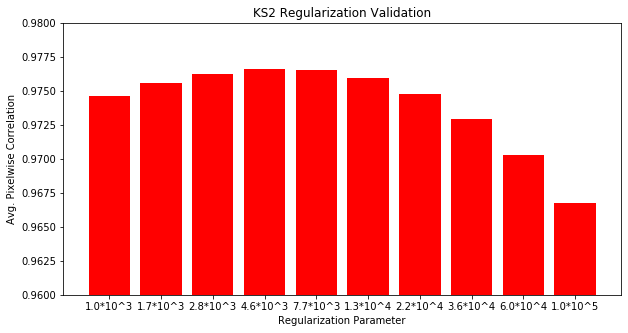

In [36]:
yass_mse_file = "/ssd/joon/2017_11_29_ns/resid_yass/resid_yass_smooth_valid_corr.npy"
ks2_mse_file = "/ssd/joon/2017_11_29_ns/ks2/ks2_valid_mse.npy"
unsorted_mse_file = "/ssd/joon/2017_11_29_ns/unsorted/unsorted_valid_mse.npy"
save_dir = "/ssd/joon/2017_11_29_ns/"

valid_plot(yass_mse_file, ks2_mse_file, unsorted_mse_file, save_dir)

yass_mse_file = "/ssd/joon/2017_11_29_ns/yass/yass_valid_mse.npy"
ks2_mse_file = "/ssd/joon/2017_11_29_ns/ks2/ks2_valid_mse.npy"
unsorted_mse_file = "/ssd/joon/2017_11_29_ns/unsorted/unsorted_valid_mse.npy"
save_dir = "/ssd/joon/2017_11_29_ns/"



valid_plot(yass_mse_file, ks2_mse_file, unsorted_mse_file, save_dir)

# Correlation Calculation

In [223]:
def comb_img_corr(yass_file, ks2_file, unsorted_file, test_file, save_dir):
    ks2 = np.load(ks2_file)
    unsorted = np.load(unsorted_file)
    test = np.load(test_file)
    yass = np.load(yass_file)
    
    image_no = test.shape[0]
    
    comb_corr_array = np.empty((image_no, 2))     
    
    for i in tnrange(image_no):
        ks2_img = ks2[i,:]
        unsorted_img = unsorted[i,:]
        test_img = test[i,:]
        yass_img = yass[i,:]
        
        yass_cor = np.corrcoef(yass_img.reshape(-1), test_img.reshape(-1))[0][1]
        ks2_cor = np.corrcoef(ks2_img.reshape(-1), test_img.reshape(-1))[0][1]
        unsorted_cor = np.corrcoef(unsorted_img.reshape(-1), test_img.reshape(-1))[0][1]
        
        comb_corr_array[i,0] = yass_cor
        comb_corr_array[i,1] = ks2_cor
        comb_corr_array[i,2] = unsorted_cor
        
    np.save(os.path.join(save_dir, "smooth_yass_corr.npy"), comb_corr_array)



In [224]:
ks2_file = "/ssd/joon/2017_12_04_ns/ks2/ks2_test_decoded.npy"
unsorted_file = "/ssd/joon/2017_12_04_ns/unsorted/unsorted_test_decoded.npy"
test_file = "/ssd/joon/2017_12_04_ns/test_images.npy"
yass_file = "/ssd/joon/2017_12_04_ns/yass/yass_test_decoded.npy"
save_dir = "/ssd/joon/2017_12_04_ns/yass/"

comb_img_corr(yass_file, ks2_file, unsorted_file, test_file, save_dir)

In [45]:
def img_corr(one_file, one_test_file, two_file, two_test_file, save_dir):
    one = np.load(one_file)
    one_test = np.load(one_test_file)
    two = np.load(two_file)
    two_test = np.load(two_test_file)
    
    image_no = one_test.shape[0]
    
    comb_corr_array = np.empty((image_no, 2))     
    
    for i in tnrange(image_no):
        one_img = one[i,:]
        one_test_img = one_test[i,:]
        two_img = two[i,:]
        two_test_img = two_test[i,:]
        
        one_cor = np.corrcoef(one_img.reshape(-1), one_test_img.reshape(-1))[0][1]
        two_cor = np.corrcoef(two_img.reshape(-1), two_test_img.reshape(-1))[0][1]
        
        comb_corr_array[i,0] = one_cor
        comb_corr_array[i,1] = two_cor

    np.save(os.path.join(save_dir, "smooth_resid_ks2_corr.npy"), comb_corr_array)




In [47]:
one_file = "/ssd/joon/2017_11_29_ns/resid_ks2/resid_ks2_smooth_test_decoded.npy"
one_test_file = "/ssd/joon/2017_11_29_ns/smooth_test_images.npy"
two_file = "/ssd/joon/2017_11_29_ns/ks2/ks2_smooth_test_decoded.npy"
two_test_file = "/ssd/joon/2017_11_29_ns/smooth_test_images.npy"
save_dir = "/ssd/joon/2017_11_29_ns/resid_ks2/"


img_corr(one_file, one_test_file, two_file, two_test_file, save_dir)

# Correlation Plots

In [6]:
def corr_plot(corr_file, save_dir):
    corr_array = np.load(corr_file)
    x_val = corr_array[:,0]
    y_val = corr_array[:,1]
    
    diag_val = x_val - y_val
    
    # definitions for the axes
    left, width = 0.075, 0.625
    bottom, height = 0.075, 0.575
    spacing = 0.045


    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]
    rect_diag = [left + width + spacing, bottom + height + spacing, 0.2, 0.2]

    # start with a rectangular Figure
    plt.figure(figsize=(9, 9.5))
    #plt.suptitle("DropSmooth YASS vs. Smooth KS2 Correlation Comparison")

    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=True)
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=True)
    ax_diag = plt.axes(rect_diag)
    ax_diag.tick_params(direction='in', labelbottom=True, labelleft = True)

    # the scatter plot:
    ax_scatter.scatter(x_val, y_val)
    ax_scatter.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), 2, c= "red", linestyle=':')

    # now determine nice limits by hand:
    binwidth = 0.025
    ax_scatter.set_xlim((0.6, 1))
    ax_scatter.set_ylim((0.6, 1))

    bins = np.arange(0, 1, binwidth)
    diag_bins = np.arange(-0.1, 0.1, 0.015)
    
    ax_histx.hist(x_val, bins=bins)
    ax_histy.hist(y_val, bins=bins, orientation='horizontal')
    ax_diag.hist(diag_val, bins = diag_bins)
    ax_diag.axvline(x=0,  c= "red", linestyle=':')

    ax_histx.set_xlim(ax_scatter.get_xlim())
    ax_histy.set_ylim(ax_scatter.get_ylim())
    #ax_histx.set_yticks([0,2,4,6,8,10,12])
    #ax_histy.set_xticks([0,2,4,6,8,10])
    
    ax_histx.set_ylabel("Image Count")
    ax_histy.set_xlabel("Image Count")
    ax_scatter.set_xlabel("Smooth YASS + Resid R Coeff")
    ax_scatter.set_ylabel("Smooth YASS R Coeff ")
    ax_diag.set_xlabel("Smooth YASS + Resid - Smooth YASS R")
    
    #plt.savefig(os.path.join(save_dir, "circle_yass_corr_plot.png"), dpi = 150)



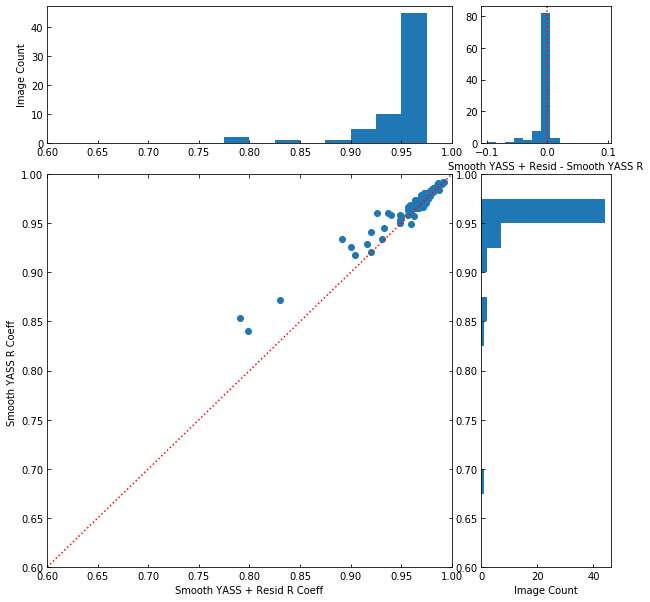

In [7]:
corr_file = "/ssd/joon/2017_11_29_ns/resid_yass/smooth_resid_yass_corr.npy"
save_dir = "/ssd/joon/2017_11_29_ns/"

corr_plot(corr_file, save_dir)


# Decoding Plots

In [48]:
def indiv_compare_plots(stim_images_file, yass_file, ks2_file, corr_file, image_no):
    yass_images = np.load(yass_file)
    ks2_images = np.load(ks2_file)
    stim_images = np.load(stim_images_file)
    unsorted_images = np.load(unsorted_file)
    
    corr_values = np.load(corr_file)
    yass_corr = np.round(corr_values[image_no, 0], 4)
    ks2_corr = np.round(corr_values[image_no, 1], 4)
    unsorted_corr = np.round(corr_values[image_no, 2], 4)
    
    yass_image = yass_images[image_no,:].reshape((160,256))
    ks2_image = ks2_images[image_no,:].reshape((160,256))
    stim_image = stim_images[image_no ,:].reshape((160,256))
    unsorted_image = unsorted_images[image_no, :].reshape((160,256))
    
    fig, axs = plt.subplots(ncols=4, figsize=(15,5))
 
    stim = axs[0].imshow(stim_image, cmap='Greys_r')
    axs[0].set_title("Stimulus: "+"Image "+str(image_no))
    axs[0].axis('off')
    
    yass = axs[1].imshow(yass_image, cmap='Greys_r')
    axs[1].set_title("Smooth YASS: "+"Image "+str(image_no) + " Corr: " + str(yass_corr))
    axs[1].axis('off')
    
    ks2 = axs[2].imshow(ks2_image, cmap='Greys_r')
    axs[2].set_title("KS2: "+"Image "+str(image_no) + " Corr: " + str(ks2_corr))
    axs[2].axis('off')
    
    unsorted = axs[3].imshow(unsorted_image, cmap='Greys_r')
    axs[3].set_title("Unsorted: "+"Image "+str(image_no) + " Corr: " + str(unsorted_corr))
    axs[3].axis('off')
    
    fig.tight_layout()
    
    
def multi_compare_plots(stim_images_file, yass_file, ks2_file, corr_file, save_dir, plot_no):
    
    with PdfPages(os.path.join(save_dir, "smooth_decoders_comparison.pdf")) as pdf:
        for i in tnrange(0,plot_no):
            image_no = np.random.randint(0, 100)
            fig = indiv_compare_plots(stim_images_file, yass_file, ks2_file, corr_file, image_no)
            pdf.savefig(fig)


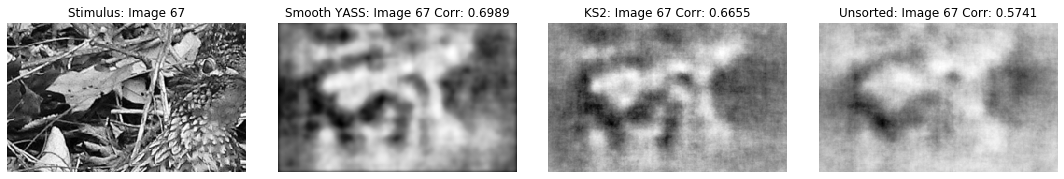

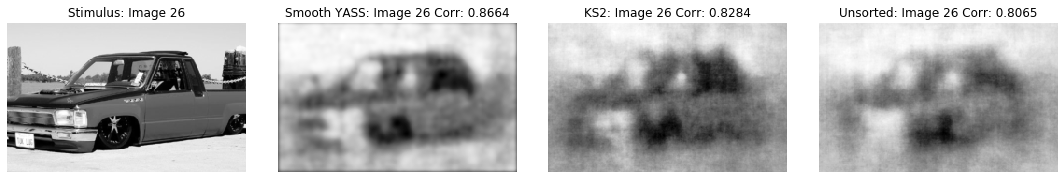

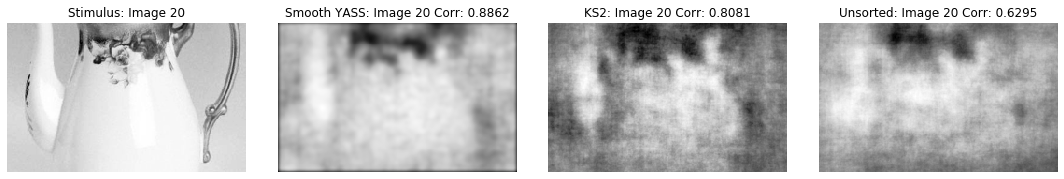

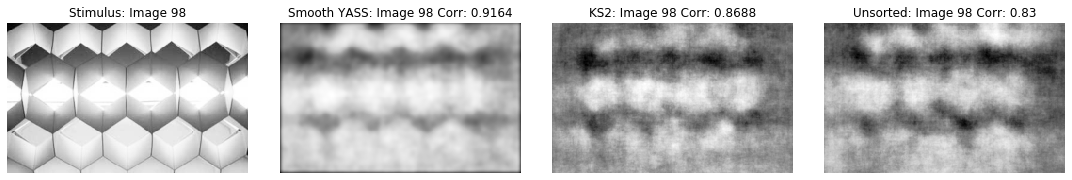

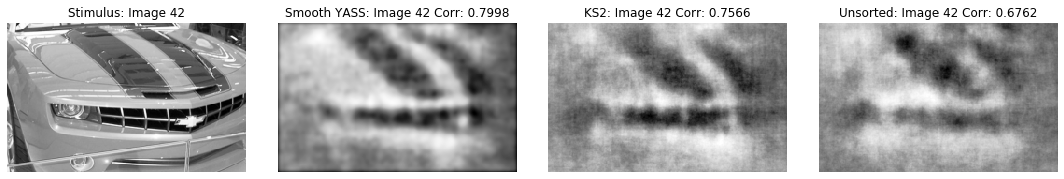

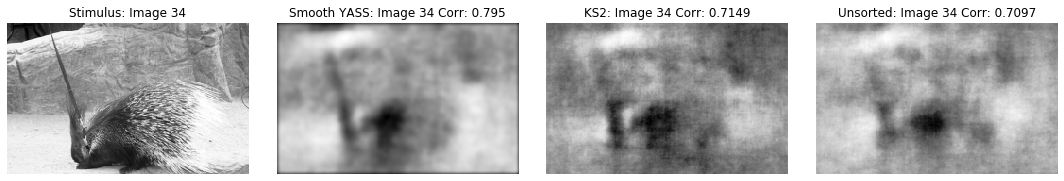

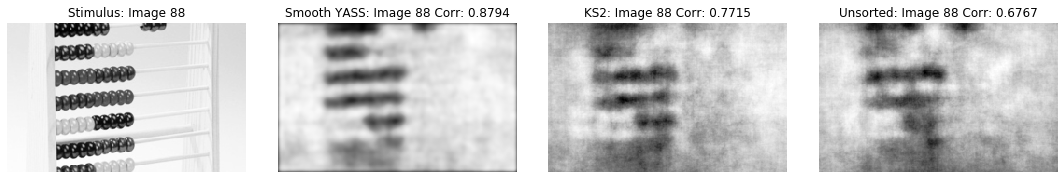

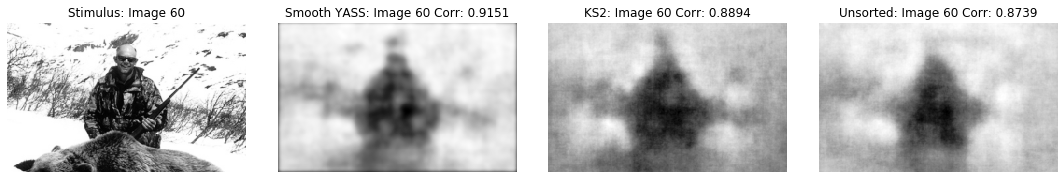

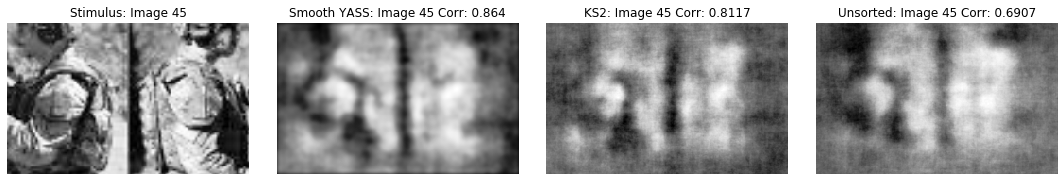

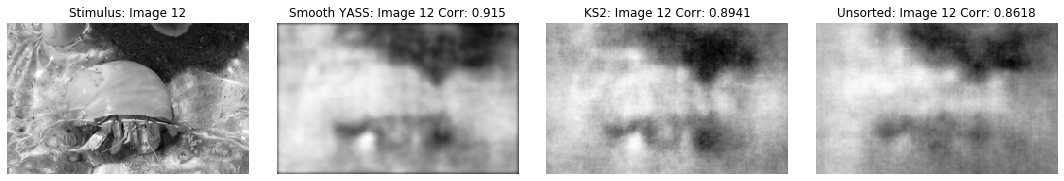

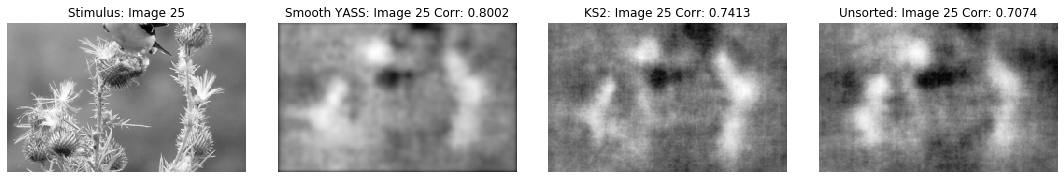

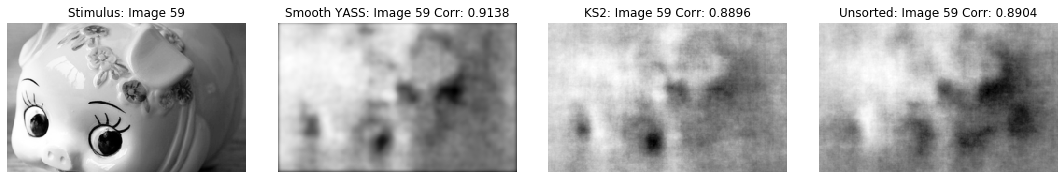

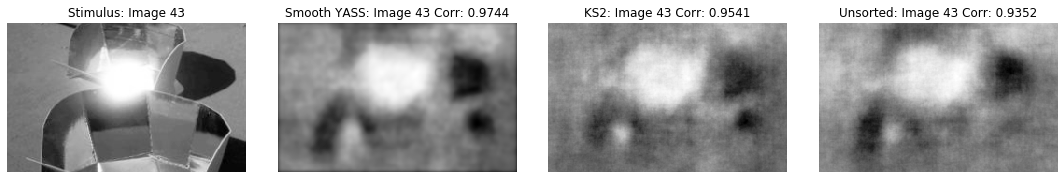

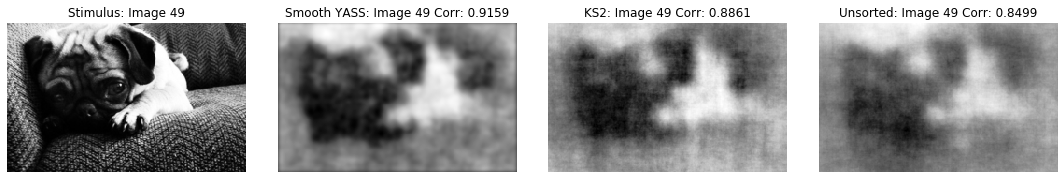

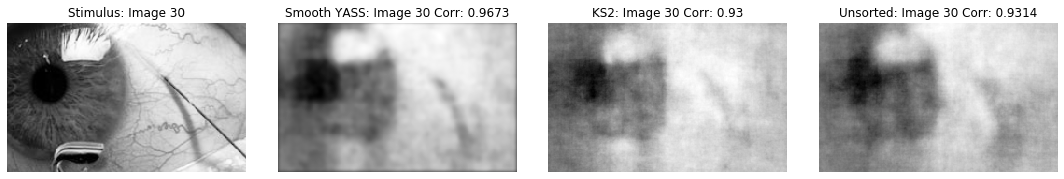

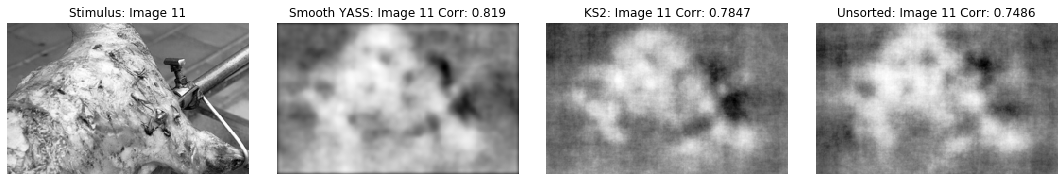

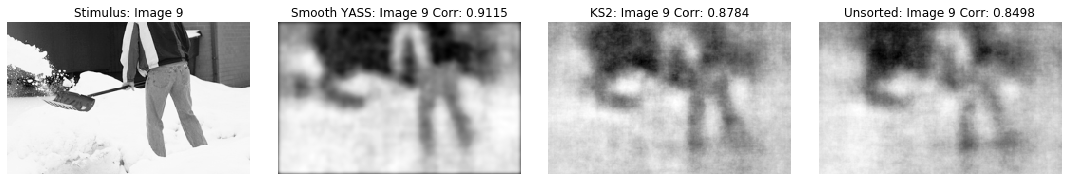

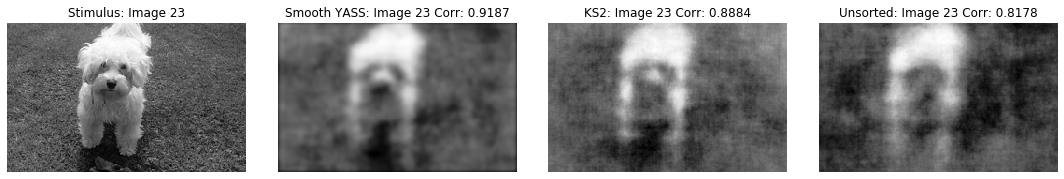

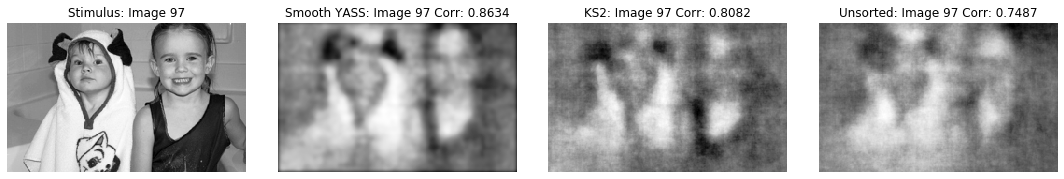

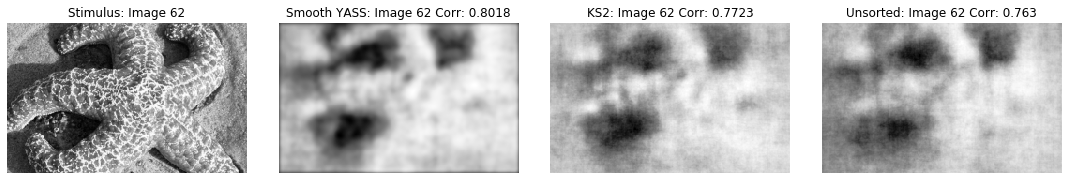

In [49]:
yass_file = "/ssd/joon/2017_11_29_ns/yass/yass_smooth_test_decoded.npy"
ks2_file = "/ssd/joon/2017_11_29_ns/ks2/ks2_test_decoded.npy"
unsorted_file = "/ssd/joon/2017_11_29_ns/unsorted/unsorted_test_decoded.npy"
stim_images_file = "/ssd/joon/2017_11_29_ns/test_images.npy"
save_dir = "/ssd/joon/2017_11_29_ns/"
corr_file = "/ssd/joon/2017_11_29_ns/smooth_combined_corr.npy"
plot_no = 20
   
multi_compare_plots(stim_images_file, yass_file, ks2_file, corr_file, save_dir, plot_no)

# Power Spectral Density Plots

In [72]:
def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape) #y from 0 to 160, x from 0 to 256
    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])
    
    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof



In [94]:
yass_decoded = np.load("/ssd/joon/2017_11_29_ns/yass/yass_test_decoded.npy")
tests = np.load("//ssd/joon/2017_11_29_ns/test_images.npy")
ks2_decoded = np.load("/ssd/joon/2017_11_29_ns/ks2/ks2_test_decoded.npy")
unsorted_decoded= np.load("/ssd/joon/2017_11_29_ns/unsorted/unsorted_test_decoded.npy")

test_yass = tests - yass_decoded
test_ks2 = tests - ks2_decoded
test_unsorted = tests - unsorted_decoded

test_power = np.zeros((160, 256))
test_yass_power = np.zeros((160, 256))
test_ks2_power = np.zeros((160, 256))
yass_power = np.zeros((160, 256))
ks2_power = np.zeros((160, 256))

for i in range(tests.shape[0]):
    test_image = tests[i,:].reshape((160,256))
    yass_image = ks2_decoded[i,:].reshape((160,256))
    ks2_image = yass_decoded[i,:].reshape((160,256))
    test_yass_image = test_yass[i,:].reshape((160,256))
    test_ks2_image = test_ks2[i,:].reshape((160,256))
    
    F1 = fftpack.fft2(test_image)
    F2 = fftpack.fft2(yass_image)
    F3 = fftpack.fft2(ks2_image)
    F4 = fftpack.fft2(test_yass_image)
    F5 = fftpack.fft2(test_ks2_image)

    F6 = fftpack.fftshift(F1)
    F7 = fftpack.fftshift(F2)
    F8 = fftpack.fftshift(F3)
    F9 = fftpack.fftshift(F4)
    F10 = fftpack.fftshift(F5)
    
    psd2D_1 = np.abs(F6) ** 2
    psd2D_2 = np.abs(F7) ** 2
    psd2D_3 = np.abs(F8) ** 2
    psd2D_4 = np.abs(F9) ** 2
    psd2D_5 = np.abs(F10) ** 2
    
    test_power += psd2D_1
    yass_power += psd2D_2
    ks2_power += psd2D_3
    test_yass_power += psd2D_4
    test_ks2_power += psd2D_5

    
test_power = test_power/tests.shape[0]
test_yass_power = test_yass_power/tests.shape[0]
test_ks2_power = test_ks2_power/tests.shape[0]
yass_power = yass_power/tests.shape[0]
ks2_power = ks2_power/tests.shape[0]

psd1D_test = azimuthalAverage(test_power)
psd1D_test_yass = azimuthalAverage(test_yass_power)
psd1D_test_ks2 = azimuthalAverage(test_ks2_power)
psd1D_yass = azimuthalAverage(yass_power)
psd1D_ks2 = azimuthalAverage(ks2_power)
    
    

    





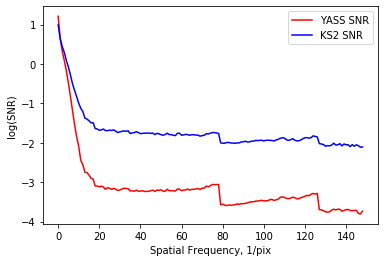

In [99]:

plt.figure()
plt.clf()
plt.plot(np.log(psd1D_yass) - np.log(psd1D_test_yass), color = "Red", label = "YASS SNR")
plt.plot(np.log(psd1D_ks2) - np.log(psd1D_test_ks2), color = "Blue", label = "KS2 SNR")
#plt.semilogy(np.log(psd1D_test) - np.log(psd1D_test_yass), color = "Black", label = "Test")
plt.xlabel("Spatial Frequency, 1/pix")
plt.ylabel("log(SNR)")
#plt.yticks([10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000, 10000000000, 100000000000])
plt.legend()

plt.show()




#plt.imshow(np.log10(test_ks2_power))
#plt.imshow(test_image)

# Residuals Comparison Plot

In [220]:
def residual_plot(test_file,  test_smooth_file, yass_file, ks2_file, unsorted_file, index, save_dir):
    test_images = np.load(test_file)
    yass_images = np.load(yass_file)
    ks2_images = np.load(ks2_file)
    unsorted_images = np.load(unsorted_file)
    smooth_images = np.load(test_smooth_file)
    
    test = test_images[index,:].reshape((95, 146))
    yass = yass_images[index,:].reshape((95, 146))
    ks2 = ks2_images[index,:].reshape((95, 146))
    unsorted = unsorted_images[index,:].reshape((160,256))[25:-40,50:-60]
    smooth = smooth_images[index,:].reshape((95, 146))
    
    test_yass = smooth - yass
    test_ks2 = test - ks2
    test_unsorted = test - unsorted
    
    test_min = np.min(test)
    test_max = np.max(test)
    yass_min = np.min(yass)
    yass_max = np.max(yass)
    ks2_min = np.min(ks2)
    ks2_max = np.max(ks2)
    unsorted_min = np.min(unsorted)
    unsorted_max = np.max(unsorted)
    
    test_yass_min = np.min(test_yass)
    test_yass_max = np.max(test_yass)
    test_ks2_min = np.min(test_ks2)
    test_ks2_max = np.max(test_ks2)
    test_unsorted_min = np.min(test_unsorted)
    test_unsorted_max = np.max(test_unsorted)
    
    decode_min = min([test_min, yass_min, ks2_min, unsorted_min])
    decode_max = max([test_max, yass_max, ks2_max, unsorted_max])
    resid_min = min([test_yass_min, test_ks2_min, test_unsorted_min])
    resid_max = max([test_yass_max, test_ks2_max, test_unsorted_max])
    
    fig, axs = plt.subplots(nrows=3, ncols = 3, figsize = (10.5, 7.7))
    test_plot = axs[1,0].imshow(test, cmap = "Greys_r", vmin = decode_min, vmax = decode_max)
    axs[0,0].imshow(smooth , cmap = "Greys_r", vmin = decode_min, vmax = decode_max)
    axs[0,0].set_title("True Smooth Image")
    axs[1,0].set_title("True Image")
    #fig.colorbar(test_plot, ax=axs[0,0])
    
    yass_plot = axs[0,1].imshow(yass, cmap = "Greys_r", vmin = decode_min, vmax = decode_max)
    #fig.colorbar(yass_plot, ax=axs[0,1])
    axs[0,1].set_title("SmoothYASS")
    axs[1,1].set_title("YASS")
    #axs[2,1].set_title("Unsorted")
    axs[1,1].imshow(ks2, cmap = "Greys_r", vmin = decode_min, vmax = decode_max)
    #axs[2,1].imshow(unsorted, cmap = "Greys_r", vmin = decode_min, vmax = decode_max)
    
    axs[0,0].axis("off")
    axs[1,0].axis("off")
    axs[2,0].axis("off")
    axs[0,1].axis("off")
    axs[1,1].axis("off")
    axs[2,1].axis("off")
    axs[0,2].axis("off")
    axs[1,2].axis("off")
    axs[2,2].axis("off")
    
    
    test_yass_plot = axs[0,2].imshow(test_yass, cmap = "Greys_r", vmin = resid_min, vmax = resid_max)
    #fig.colorbar(test_yass_plot, ax=axs[0,2])
    axs[0,2].set_title("SmoothTest-SmoothYASS")
    axs[1,2].imshow(test_ks2, cmap = "Greys_r", vmin = resid_min, vmax = resid_max)
    axs[1,2].set_title("Test-YASS")
    #axs[2,2].imshow(test_unsorted, cmap = "Greys_r", vmin = resid_min, vmax = resid_max)
    #axs[2,2].set_title("Test-Unsorted")
    
    fig.suptitle("Image " + str(index) + ": Residuals Comparison", fontsize = 16, y = 0.95)
    #fig.tight_layout

def multi_residual_plot(test_file, test_smooth_file, yass_file, ks2_file, unsorted_file, index_no, save_dir):
    with PdfPages(os.path.join(save_dir, "smooth_residuals_comparison.pdf")) as pdf:
        for i in tnrange(0,index_no):
            index = np.random.randint(0, 100)
            fig = residual_plot(test_file, test_smooth_file, yass_file, ks2_file, unsorted_file, index, save_dir)
            pdf.savefig(fig)
    
    

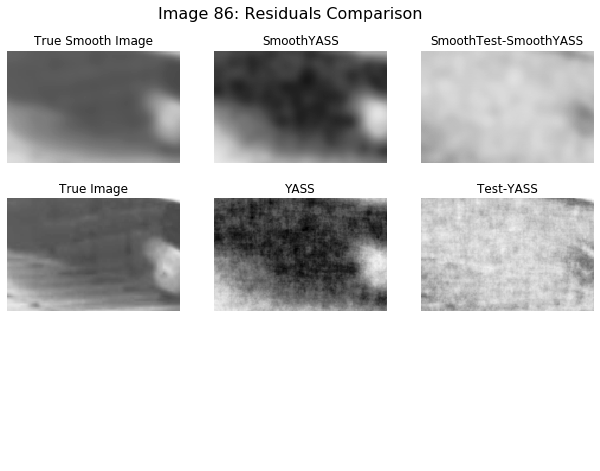

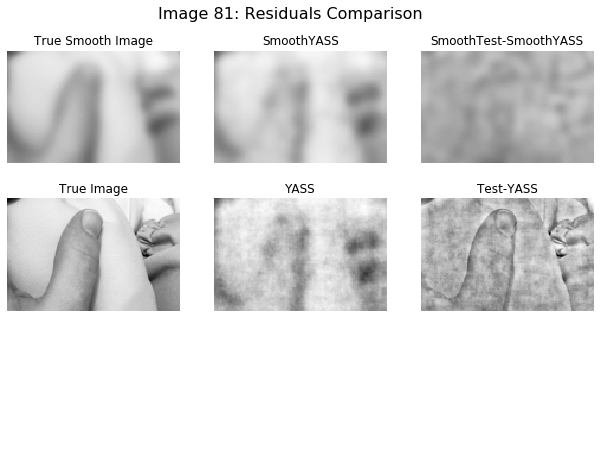

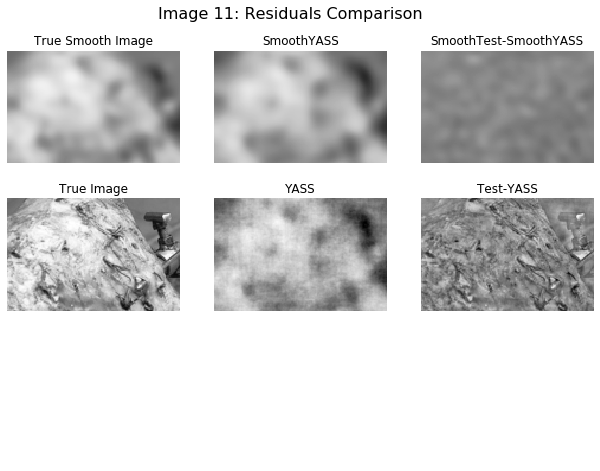

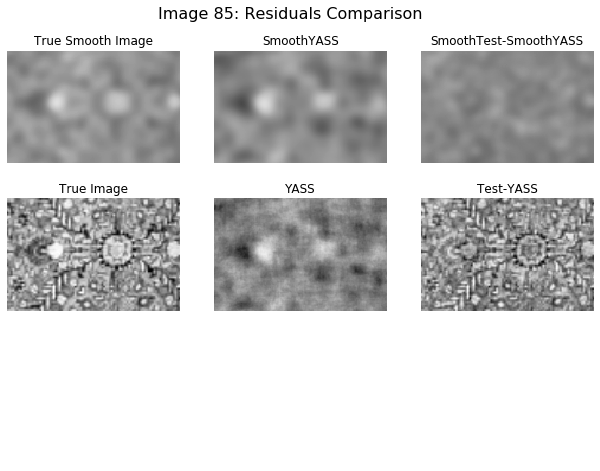

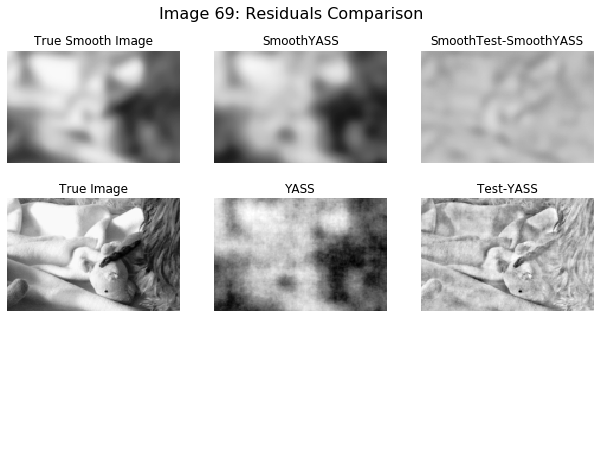

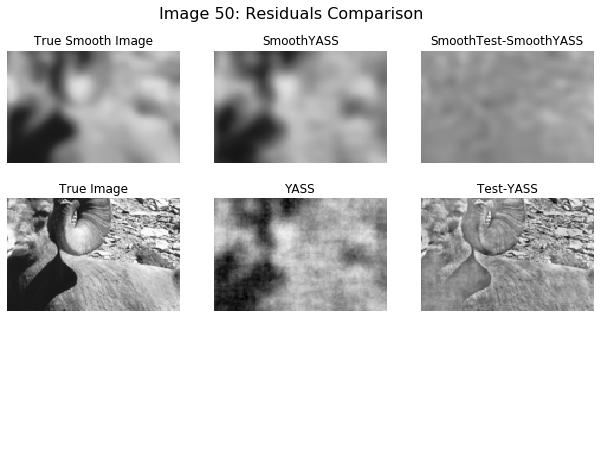

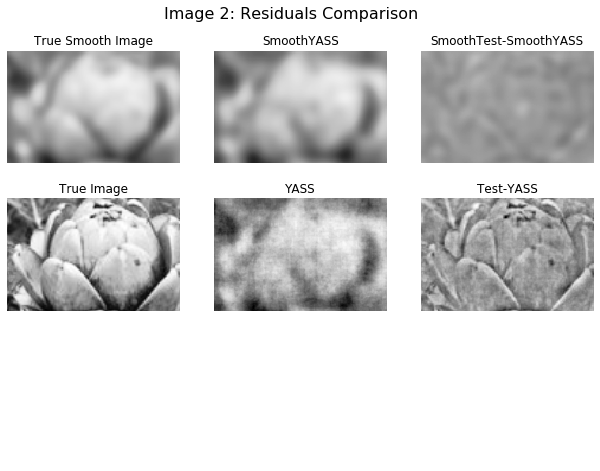

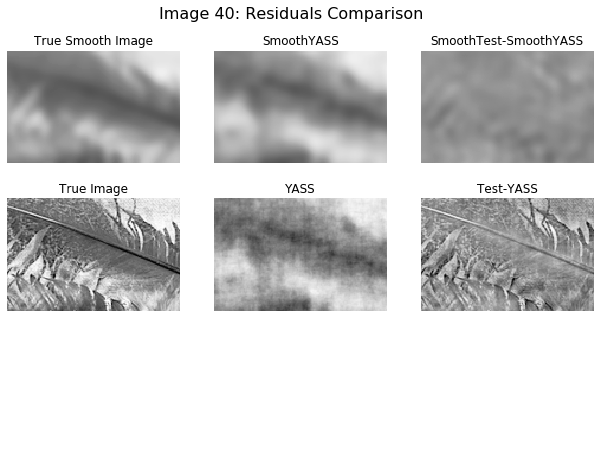

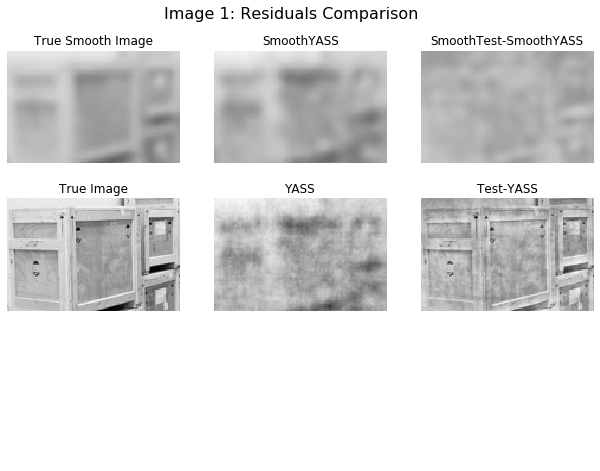

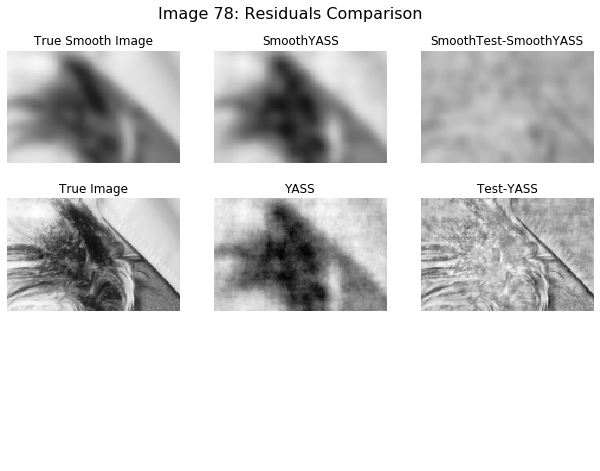

In [221]:
index_no = 10

test_file = "/ssd/joon/2017_11_29_ns/test_images.npy"
yass_file = "/ssd/joon/2017_11_29_ns/yass/yass_smooth_test_decoded.npy"
ks2_file = "/ssd/joon/2017_11_29_ns/yass/yass_test_decoded.npy"
unsorted_file = "/ssd/joon/2017_11_29_ns/unsorted/unsorted_test_decoded.npy"
save_dir = "/ssd/joon/2017_11_29_ns/"

test_smooth_file = "/ssd/joon/2017_11_29_ns/smooth_test_images.npy"

multi_residual_plot(test_file, test_smooth_file, yass_file, ks2_file, unsorted_file, index_no, save_dir)


# Pixel Correlation Plot

In [41]:
def pixel_corr_plot(test_file, yass_file, ks2_file, unsorted_file, save_dir):
    test = np.load(test_file) ###[0:-25,15:-20]
    yass = np.load(yass_file)
    ks2 = np.load(ks2_file)
    unsorted = np.load(unsorted_file)
    
    yass_corr_array = np.empty((160*256))
    unsorted_corr_array = np.empty((160*256))
    ks2_corr_array = np.empty((160*256))
    
    for i in tnrange(160*256):
        test_pixels = test[:,i]
        yass_pixels = yass[:,i]
        ks2_pixels = ks2[:,i]
        unsorted_pixels = unsorted[:,i]
        
        yass_corr = np.corrcoef(yass_pixels, test_pixels)[0][1]
        ks2_corr = np.corrcoef(ks2_pixels, test_pixels)[0][1]
        unsorted_corr = np.corrcoef(unsorted_pixels, test_pixels)[0][1]
        
        yass_corr_array[i] = yass_corr
        ks2_corr_array[i] = ks2_corr
        unsorted_corr_array[i] = unsorted_corr
        
    yass_corr_array = yass_corr_array.reshape((160,256))
    ks2_corr_array = ks2_corr_array.reshape((160,256))
    unsorted_corr_array = unsorted_corr_array.reshape((160,256))
    
    fig, ax = plt.subplots(ncols = 3, figsize = (7,2))
    
    vmin = np.min([yass_corr_array[25:-40,50:-60], ks2_corr_array[25:-40,50:-60], unsorted_corr_array[25:-40,50:-60]])
    vmax = np.max([yass_corr_array[25:-40,50:-60], ks2_corr_array[25:-40,50:-60], unsorted_corr_array[25:-40,50:-60]])
    
    yass_plot = ax[0].imshow(yass_corr_array[25:-40,50:-60], vmin = vmin, vmax = vmax, cmap = "jet")
    ax[1].imshow(ks2_corr_array[25:-40,50:-60], vmin = vmin, vmax = vmax, cmap = "jet")
    ax[2].imshow(unsorted_corr_array[25:-40,50:-60], vmin = vmin, vmax = vmax, cmap = "jet")
    plt.colorbar(yass_plot, ax = ax[0], shrink = 0.65)
    #plt.colorbar(yass_plot, ax = ax[1], shrink = 0.65)
    #plt.colorbar(yass_plot, ax = ax[2], shrink = 0.65)
    
    ax[0].set_title("YASS")
    ax[0].axis("off")
    ax[1].set_title("KS2")
    ax[1].axis("off")
    ax[2].set_title("Unsorted")
    ax[2].axis("off")
    
    
    #fig.suptitle("Decoder Pixel Correlation")
    




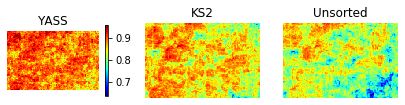

In [42]:
test_file = "/ssd/joon/2017_11_29_ns/test_images.npy"
yass_file = "/ssd/joon/2017_11_29_ns/yass/yass_test_decoded.npy"
ks2_file = "/ssd/joon/2017_11_29_ns/ks2/ks2_test_decoded.npy"
unsorted_file = "/ssd/joon/2017_11_29_ns/unsorted/unsorted_test_decoded.npy"
save_dir = "/ssd/joon/2017_11_29_ns/"


pixel_corr_plot(test_file, yass_file, ks2_file, unsorted_file, save_dir)

# Final Figure

In [43]:
def final_vanilla_plot(test_file, yass_file, ks2_file, unsorted_file, corr_file, save_dir):
    test = np.load(test_file)[95,:].reshape((160,256))
    yass = np.load(yass_file)[95,:].reshape((160,256))
    ks2 = np.load(ks2_file)[95,:].reshape((160,256))
    unsorted = np.load(unsorted_file)[95,:].reshape((160,256))
    
    corr = np.load(corr_file)
    yass_corr = corr[:,0]
    ks2_corr = corr[:,1]
    unsorted_corr = corr[:,2]
    
    fig = plt.figure(figsize = (11.5, 11), )
    #gs = GridSpec(3, 2, width_ratios=[1, 1], height_ratios=[1, 1, 1.6], wspace = 0.05)
    ax1 = plt.subplot2grid((3,6), (0,0), colspan = 3)
    ax2 = plt.subplot2grid((3,6), (0,3), colspan = 3)
    ax3 = plt.subplot2grid((3,6), (1,0), colspan = 3)
    ax4 = plt.subplot2grid((3,6), (1,3), colspan = 3)
    ax5 = plt.subplot2grid((3,6), (2,0), colspan = 2)
    ax6 = plt.subplot2grid((3,6), (2,2), colspan = 2)
    ax7 = plt.subplot2grid((3,6), (2,4), colspan = 2)
    
    imgmin = np.min([test, yass, ks2, unsorted])
    imgmax = np.max([test, yass, ks2, unsorted])
    
    ax1.imshow(test[25:-40,50:-60], cmap="Greys_r", vmin = imgmin, vmax = imgmax)
    ax2.imshow(yass[25:-40,50:-60], cmap="Greys_r", vmin = imgmin, vmax = imgmax)
    ax3.imshow(ks2[25:-40,50:-60], cmap="Greys_r", vmin = imgmin, vmax = imgmax)
    ax4.imshow(unsorted[25:-40,50:-60], cmap="Greys_r", vmin = imgmin, vmax = imgmax)
    
    ax1.set_title("Test Image 95", fontsize = 15)
    ax2.set_title("YASS Decoded Image", fontsize = 15)
    ax3.set_title("KS2 Decoded Image", fontsize = 15)
    ax4.set_title("Unsorted Decoded Image", fontsize = 15)
    
    ax5.scatter(ks2_corr, yass_corr, color="black", s=15)
    ax5.scatter(ks2_corr[95], yass_corr[95], color="red", s=30)
    
    ax6.scatter(ks2_corr, unsorted_corr, color="black", s=15)
    ax6.scatter(ks2_corr[95], unsorted_corr[95], color="red", s=30)
    
    ax7.scatter(unsorted_corr, yass_corr, color="black", s=15)
    ax7.scatter(unsorted_corr[95], yass_corr[95], color="red", s=30)
    
    ax5.set_xlim(0,1)
    ax5.set_ylim(0,1)
    ax6.set_xlim(0,1)
    ax6.set_ylim(0,1)
    ax7.set_xlim(0,1)
    ax7.set_ylim(0,1)
    
    
    ax5.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax5.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax6.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax6.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax7.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax7.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    
    ax5.set_title("KS2 vs. YASS Correlation", fontsize = 12)
    ax6.set_title("Unsorted vs. KS2 Correlation", fontsize = 12)
    ax7.set_title("YASS vs. Unsorted Correlation", fontsize = 12)
    ax5.plot(np.linspace(0, 0.99, 10), np.linspace(0, 0.99, 10), 2, c= "black", linestyle=':')
    ax6.plot(np.linspace(0, 0.99, 10), np.linspace(0, 0.99, 10), 2, c= "black", linestyle=':')
    ax7.plot(np.linspace(0, 0.99, 10), np.linspace(0, 0.99, 10), 2, c= "black", linestyle=':')
    
    ax5.set_xlabel("KS2 Correlation", fontsize = 12)
    ax5.set_ylabel("YASS Correlation", fontsize = 12)
    ax6.set_xlabel("KS2 Correlation", fontsize = 12)
    ax6.set_ylabel("Unsorted Correlation", fontsize = 12)
    ax7.set_xlabel("Unsorted Correlation", fontsize = 12)
    ax7.set_ylabel("YASS Correlation", fontsize = 12)
    
    ax5.set_aspect("equal")
    ax6.set_aspect("equal")
    ax7.set_aspect("equal")
    
    ax1.axis("off")
    ax2.axis("off")
    ax3.axis("off")
    ax4.axis("off")
    fig.tight_layout()
    
    fig.savefig(os.path.join(save_dir, "crop_final_figure.png"), dpi=200)
    


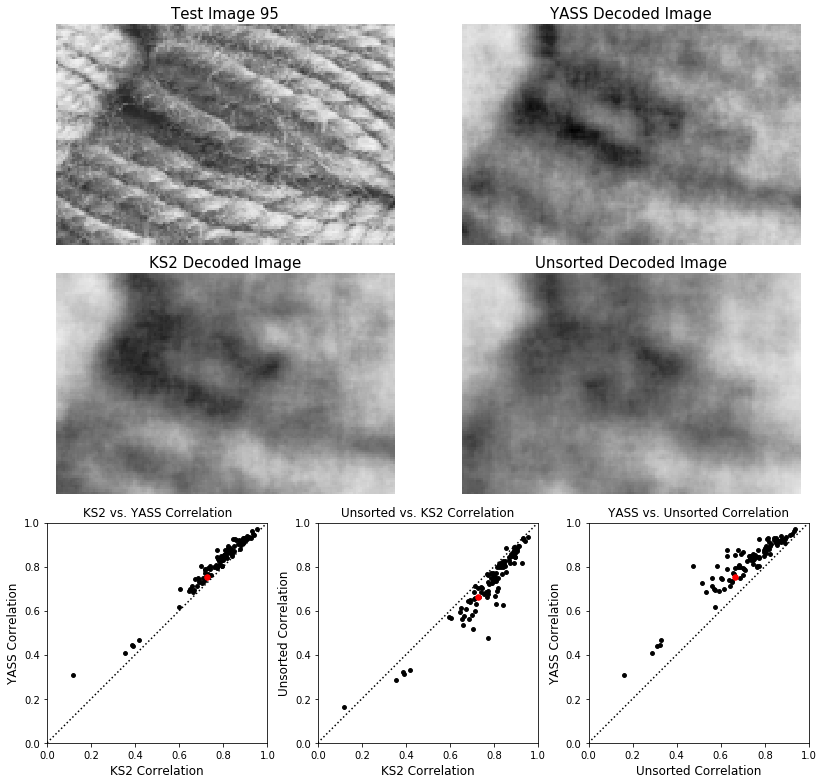

In [44]:
test_file = "/ssd/joon/2017_11_29_ns/test_images.npy"
yass_file = "/ssd/joon/2017_11_29_ns/yass/yass_test_decoded.npy"
ks2_file = "/ssd/joon/2017_11_29_ns/ks2/ks2_test_decoded.npy"
unsorted_file = "/ssd/joon/2017_11_29_ns/unsorted/unsorted_test_decoded.npy"
corr_file = "/ssd/joon/2017_11_29_ns/crop_combined_corr.npy"
save_dir = "/ssd/joon/2017_11_29_ns/"

final_vanill_plot(test_file, yass_file, ks2_file, unsorted_file, corr_file, save_dir)

# (Smooth) Residual Pixel E & V

In [11]:
def residual_scatter(test_image_file, yass_file, save_dir):
    test = np.load(test_image_file)
    yass = np.load(yass_image_file)
    
    pixels = test.shape[1]
    images = test.shape[0]
    
    scatter_array = np.empty((pixels * images, 2))
    

    for i in tnrange(images):
        for j in range(pixels):
            scatter_array[i*pixels + j,0] = test[i,j]
            
            resid = yass[i,j] - test[i,j]
            
            scatter_array[i*pixels + j,1] = resid
        
    plt.scatter(scatter_array[:,0], scatter_array[:,1], s=0.3)
    plt.xlabel("Smooth Test Image Pixel Value")
    plt.ylabel("Smooth YASS Pixel - Smooth Test Pixel")
    
    
def residual_mean_var(test_image_file, smooth_image_file, yass_file, save_dir):
    test = np.load(test_image_file)
    smooth = np.load(smooth_image_file)
    yass = np.load(yass_file)
    
    pixels = test.shape[1]
    images = test.shape[0]
    
    

    #### E(smoothTRUE - smoothYASS VS. SmoothTRUE)
    ######
    """
    scatter_array = np.empty((pixels * images, 3))
    for i in tnrange(images):
        for j in range(pixels):
            scatter_array[i*pixels + j,0] = yass[i,j]

            yass_resid = smooth[i,j] - yass[i,j]
            
            scatter_array[i*pixels + j,1] = yass_resid
            
            true_resid = smooth[i,j] - test[i,j]
            
            scatter_array[i*pixels + j, 2] = true_resid
            
    x_min = int(np.min(smooth))
    x_max = int(np.max(smooth))
    
    x_vals = np.arange(x_min, x_max + 1)
    
    mean_var_array = np.empty((x_max - x_min + 1,2))
    
    for i in tnrange(x_max - x_min + 1):
        
        resid_values = scatter_array[np.where(np.int_(scatter_array[:,0]) == i)]
        
        resid_mean = np.mean(resid_values[:,1])
        resid_var = np.var(resid_values[:,1] - resid_mean)
        
        mean_var_array[i,0] = resid_mean
        mean_var_array[i,1] = resid_var
        
    """
    
    #### E(smoothTRUE - smoothYASS) VS. SmoothYASS)
    #######
    
    smooth_min = int(np.min(yass))
    smooth_max = int(np.max(yass)) + 1
    
    smooth_yass_resid = smooth - yass
    smooth_yass_array = np.empty((smooth_max - smooth_min, 3))
    
    for i in tnrange(smooth_max - smooth_min):
        bin_pixels = smooth_yass_resid[np.where((yass >= smooth_min + i) & (yass < smooth_min + i+1))]
        bin_mean = np.mean(bin_pixels)
        bin_var = np.var(bin_pixels)
        
        smooth_yass_array[i,1] = bin_mean
        smooth_yass_array[i,2] = bin_var
        smooth_yass_array[i,0] = smooth_min + i + 0.5
        
    ###### RESIDUALS vs RESIDUALS ######
    ####
    
    """
    resid_min = int(np.min(scatter_array[:,2]))
    resid_max = int(np.max(scatter_array[:,2]))
 
    resid_bin_array = np.empty((resid_max - resid_min, 3))
    
    for i in tnrange(resid_max - resid_min):
        resid_bin = scatter_array[np.where((scatter_array[:,2] >= resid_min + i) & (scatter_array[:,2] < resid_min + i + 1))]
        resid_bin_mean = np.mean(resid_bin[:,1])
        resid_bin_var = np.var(resid_bin[:,1])
        
        resid_bin_array[i,0] = resid_min + i
        resid_bin_array[i,1] = resid_bin_mean
        resid_bin_array[i,2] = resid_bin_var
    """
    
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8,6))
    
    #fig.suptitle("SmoothYASS Residual Analysis")
    
    axs[0,0].plot(smooth_yass_array[:,0], smooth_yass_array[:,1])
    axs[0,1].plot(smooth_yass_array[:,0], smooth_yass_array[:,2])
    #axs[0,1].plot(resid_bin_array[:,0], resid_bin_array[:,1])
    #axs[1,1].plot(resid_bin_array[:,0], resid_bin_array[:,2])
    
    
    bins = np.arange(smooth_min, smooth_max + 2)
    counts, bins = np.histogram(yass, bins)
    axs[1,0].hist(bins[:-1], bins, weights=counts)
    axs[1,1].hist(bins[:-1], bins, weights=counts)
    
    #axs[1,0].hist(smooth, bins)
    #axs[1,1].hist(smooth, bins)
    
    print(smooth.shape)
    
    axs[0,0].set_xlabel("YASS Smoothed Pixel Value")
    axs[0,1].set_xlabel("YASS Smoothed Pixel Value")
    
    axs[0,0].set_ylabel("Smooth True - Smooth YASS Mean")
    axs[0,1].set_ylabel("Smooth True - Smooth YASS Variance")
    
    #axs[0,1].set_xlabel("Smooth True - True")
    #axs[1,1].set_xlabel("Smooth True - True")
    
    #axs[0,1].set_ylabel("Smooth True - Smooth YASS Mean")
    #axs[1,1].set_ylabel("Smooth True - Smooth YASS Variance")
    
    fig.tight_layout()
    
    np.save(os.path.join(save_dir, "yass_smooth_resid_mean_var.npy"), smooth_yass_array)
        
    
        
        
        


(100, 13870)


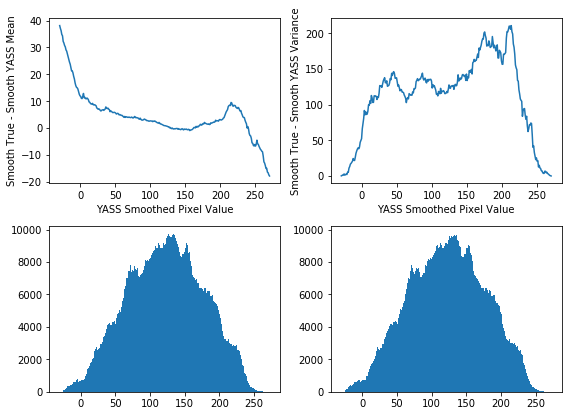

In [12]:
test_image_file = "/users/yjkimnada/2017_11_29_ns/test_images.npy"
smooth_image_file = "/users/yjkimnada/2017_11_29_ns/smooth_test_images.npy"
yass_file = "/users/yjkimnada/2017_11_29_ns/yass/yass_smooth_test_decoded.npy"
save_dir = "/users/yjkimnada/2017_11_29_ns/yass/"



residual_mean_var(test_image_file, smooth_image_file, yass_file, save_dir)

# Smooth Filter Weight Plots

In [43]:
def filter_weight_plot(smooth_weights_file, circle_weights_file, sorted_units_file, save_dir):
    weights = np.load(smooth_weights_file)
    circle_weights = np.load(circle_weights_file)
    sorted_units = np.load(sorted_units_file)
    
    total_units = np.max(sorted_units.shape[0] - 500)
    print(total_units)
    pixels = weights.shape[1]
    

    
    for i in tnrange(total_units-1):
        unit = sorted_units[i]
        fig, axs = plt.subplots(nrows = 2, ncols =2, figsize = (8,6), dpi = 80)
        on_img = axs[0,0].imshow(weights[unit*2,:].reshape((95,146)))
        off_img = axs[1,0].imshow(weights[unit*2 + 1,:].reshape((95,146)))
        
        on_circle = axs[0,1].imshow(circle_weights[i*2,:].reshape((95,146)))
        off_circle = axs[1,1].imshow(circle_weights[i*2 + 1,:].reshape((95,146)))
        
        axs[0,0].axis("off")
        axs[0,0].set_title("Index" + str(i) + " Unit" + str(unit) + " ON")
        axs[1,0].axis("off")
        axs[1,0].set_title("Index" + str(i) + " Unit" + str(unit) + " OFF")
        plt.colorbar(on_img, ax=axs[0,0], shrink = 0.7)
        plt.colorbar(off_img, ax=axs[1,0], shrink = 0.7)
        
        axs[0,1].axis("off")
        axs[0,1].set_title("Index" + str(i) + " Unit" + str(unit) + " ON")
        axs[1,1].axis("off")
        axs[1,1].set_title("Index" + str(i) + " Unit" + str(unit) + " OFF")
        plt.colorbar(on_img, ax=axs[0,1], shrink = 0.7)
        plt.colorbar(off_img, ax=axs[1,1], shrink = 0.7)
   
        fig.tight_layout()
        fig.savefig(os.path.join(save_dir, "index" + str(i) + "_unit" +str(unit)) + "_circle_weights.png")
        plt.close()
    
    
    
    
    
    
    
    
    

1594


KeyboardInterrupt: 

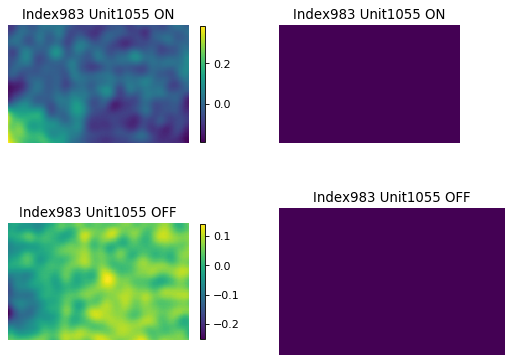

In [44]:
smooth_weights_file = "/ssd/joon/2017_11_29_ns/yass/yass_smooth_4_weights.npy"
circle_weights_file = "/ssd/joon/2017_11_29_ns/yass/yass_circle_3_weights.npy"
save_dir = "/ssd/joon/2017_11_29_ns/yass/circle_weights/"
sorted_units_file = "/ssd/joon/2017_11_29_ns/yass/yass_weight_sorted_units.npy"


filter_weight_plot(smooth_weights_file,circle_weights_file , sorted_units_file, save_dir)

In [ ]:
def weight_sort_units(weights_file, save_dir):
    weights = np.load(weights_file)
    
    
    for i in range(weights)
    